# Librerias

In [1]:
#import sys 
#!{sys.executable} -m pip install pyarrow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from datetime import date, time, datetime, timedelta

pd.options.display.float_format = '{:.3f}'.format

# Datos

Se asume que los datos reales son el archivo que contiene en el nombre 0006 y el otro archivo los datos sinteticos.

In [3]:
datos_reales=pd.read_parquet('sample_data_0006_part_00.parquet', engine='pyarrow')
datos_sinteticos=pd.read_parquet('sample_data_0007_part_00.parquet', engine='pyarrow')

# Modificacion de datos

Para la variable transaction_date se le quita la hora y transaction_amount se cambia el tipo de dato.

In [4]:
datos_reales['transaction_amount'] = datos_reales['transaction_amount'].astype('float64')
datos_sinteticos['transaction_amount'] = datos_sinteticos['transaction_amount'].astype('float64')

datos_reales['fecha'] = pd.to_datetime(datos_reales['transaction_date']).dt.date
datos_sinteticos['fecha'] = pd.to_datetime(datos_sinteticos['transaction_date']).dt.date

datos_reales['fecha'] = pd.to_datetime(datos_reales['fecha'], format='%Y/%m/%d')
datos_sinteticos['fecha'] = pd.to_datetime(datos_sinteticos['fecha'], format='%Y/%m/%d')

In [5]:
datos_reales.head()

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fecha
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.334,CREDITO,2021-09-12
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.667,CREDITO,2021-09-12
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.667,CREDITO,2021-09-12
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.322,CREDITO,2021-09-12
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.100,CREDITO,2021-09-12


# Analisis de los datos

In [6]:
print("Cantidad de Trx:",datos_reales.shape[0])
print("Cantidad de Cuentas:",len(datos_reales['account_number'].unique()))
print("Cantidad de Clientes:",len(datos_reales['user_id'].unique()))
print("Fecha mas Antigua:",datos_reales['fecha'].min())
print("Fecha mas Reciente:",datos_reales['fecha'].max())
print("Cantidad de Trx Debito (Salidas):",datos_reales["transaction_type"].value_counts()[0])
print("Valor de Trx Debito (Salidas): {:,.2f}".format(datos_reales.groupby('transaction_type').agg({'transaction_amount':'sum'}).reset_index().loc[1,'transaction_amount']))
print("Cantidad de Trx Credito (Entradas):",datos_reales["transaction_type"].value_counts()[1])
print("Valor de Trx Credito (Entradas): {:,.2f}".format(datos_reales.groupby('transaction_type').agg({'transaction_amount':'sum'}).reset_index().loc[0,'transaction_amount']))

Cantidad de Trx: 10758418
Cantidad de Cuentas: 1954040
Cantidad de Clientes: 1948844
Fecha mas Antigua: 2021-01-01 00:00:00
Fecha mas Reciente: 2021-11-30 00:00:00
Cantidad de Trx Debito (Salidas): 8591289
Valor de Trx Debito (Salidas): 1,760,152,656.13
Cantidad de Trx Credito (Entradas): 2167129
Valor de Trx Credito (Entradas): 298,980,570.81


La informacion se encuentra en una ventana de tiempo de 11 meses, iniciando en enero del año 2021 hasta noviembre del mismo año, en donde se presentan casi 11 millones de Trx, se utilizaron cerca de 2 millones de cuentas, con montos totales de entradas de dinero de 298 mil millones y salidas de 1,7 billones.

# Caso de analisis

Se busca identificar transacciones con mala practica, en este caso transacciones que se fraccionan y en vez de realizar una sola transaccion, se realizan varias con menor valor.

Para lograr descubrir dichas transacciones, se realizaran los siguientes pasos en la base de datos reales:

1. Revisar la distribucion de la cantidad de transacciones que se realizan en las cuentas cada dia, discriminando por el tipo de transaccion

In [7]:
base=datos_reales.groupby(["account_number","transaction_type","fecha"]).agg(
    {'_id':'count','transaction_amount':'sum'}).reset_index()
base = base.rename(columns={'_id':'Cantidad','transaction_amount':'Valor'})
base_credito=base[base['transaction_type']=='CREDITO']
base_debito=base[base['transaction_type']=='DEBITO']
del base

In [8]:
base_credito

,account_number,transaction_type,fecha,Cantidad,Valor
1,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,2021-05-26,1,107.000
2,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,2021-05-28,1,178.334
3,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,2021-06-02,1,118.889
4,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,2021-07-12,1,59.445
8,00001500d5a76e12b28c233bf1f8718b,CREDITO,2021-04-05,1,35.667
...,...,...,...,...,...
9293062,ffffc060f85f109fe176e91b6483a066,CREDITO,2021-04-05,1,237.778
9293076,ffffc3558b92b39e785c1d91546a59a6,CREDITO,2021-09-28,1,95.111
9293081,ffffee41fbc3a77296e0b8d1cf56b3b0,CREDITO,2021-10-27,1,59.445
9293082,ffffee41fbc3a77296e0b8d1cf56b3b0,CREDITO,2021-11-07,1,332.889


Text(0.5, 1.0, 'Cant Trx por Cuenta y Dia (Debito)')

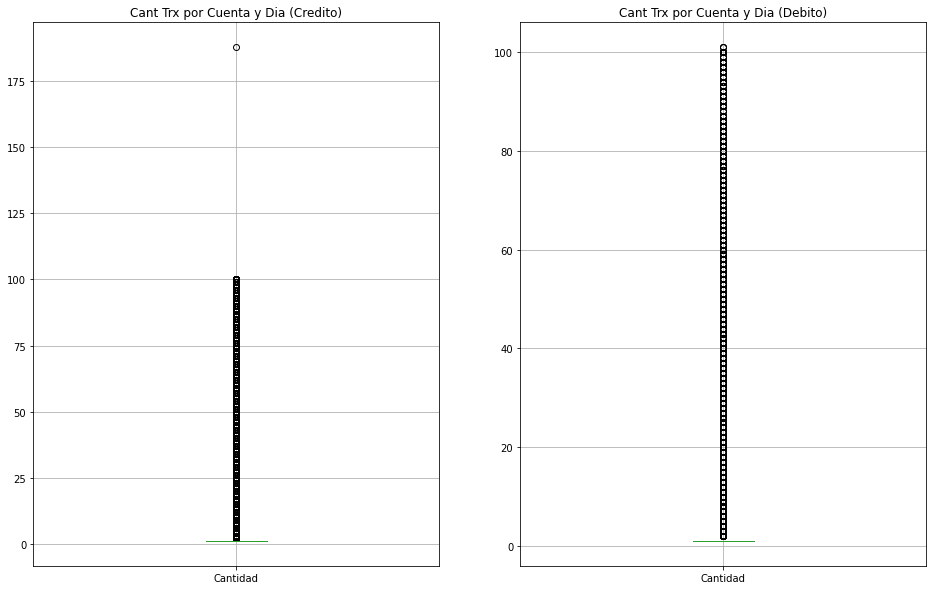

In [9]:
plt.figure(figsize=(16,10))

plt.subplot(1,2,1)
boxplot = base_credito.boxplot(column=['Cantidad'])
plt.title("Cant Trx por Cuenta y Dia (Credito)")
plt.subplot(1,2,2)
boxplot = base_debito.boxplot(column=['Cantidad'])
plt.title("Cant Trx por Cuenta y Dia (Debito)")

#plt.boxplot(base_credito['n'])
#plt.title("Cant Trx por Cuenta y Dia")
#plt.show()

La mayor cantidad de transacciones se ubica en valores pequeños cercanos a uno, para ambos tipos de transacciones

In [10]:
print('Quantiles')
print('--------------------------')
print('Tipo de Transaccion Debito')
print(base_debito["Cantidad"].quantile([.9,.95,.99,.995,.999]))
print('--------------------------')
print('Tipo de Transaccion Credito')
print(base_credito["Cantidad"].quantile([.9,.95,.99,.995,.999]))

Quantiles
--------------------------
Tipo de Transaccion Debito
0.900   1.000
0.950   2.000
0.990   3.000
0.995   4.000
0.999   5.000
Name: Cantidad, dtype: float64
--------------------------
Tipo de Transaccion Credito
0.900    1.000
0.950    2.000
0.990    4.000
0.995    4.000
0.999   39.000
Name: Cantidad, dtype: float64


El 0,1% del total de cuentas en los movimiento de tipo Debito realizaron 5 transacciones o mas en un mismo dia, para el caso de cuentas en los movimiento de tipo Credito el 0,1% realizaron 39 transacciones o mas.

In [11]:
base_credito=base_credito[base_credito['Cantidad']>=39]
base_debito=base_debito[base_debito['Cantidad']>=5]

In [12]:
print("Cuentas >= 5 Trx Debito en un dia:",len(base_debito['account_number'].unique()))
print("Cuentas >= 39 Trx Credito en un dia:",len(base_credito['account_number'].unique()))

Cuentas >= 5 Trx Debito en un dia: 8387
Cuentas >= 39 Trx Credito en un dia: 1115


Con los valores de corte definidos procedemos a observar cual seria el numero de cuentas a revisar.

Text(0.5, 1.0, 'Cantidad de cuentas para revisar (Debito)')

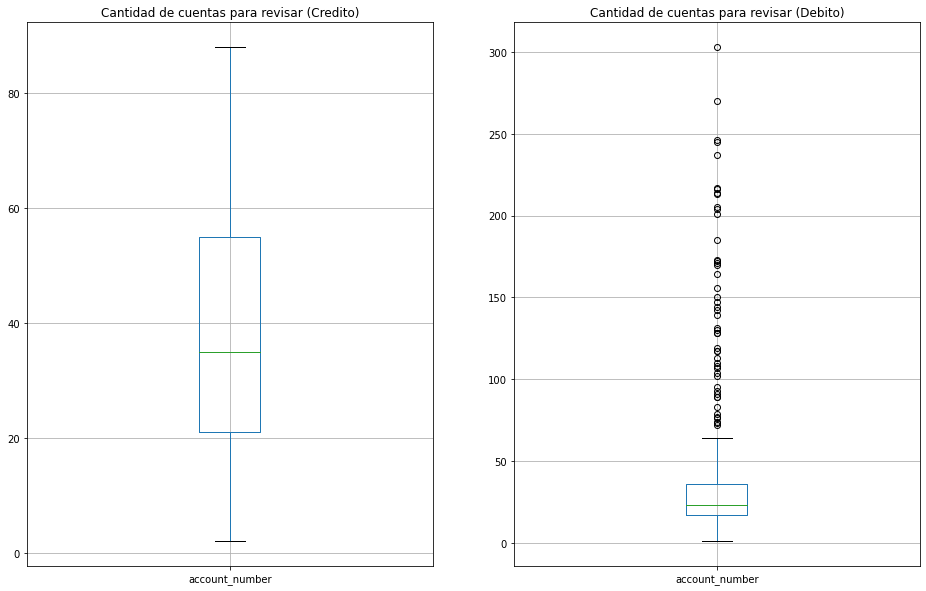

In [13]:
plt.figure(figsize=(16,10))

plt.subplot(1,2,1)
boxplot = base_credito.groupby('fecha')['account_number'].count().reset_index().boxplot(column=['account_number'])
plt.title("Cantidad de cuentas para revisar (Credito)")
plt.subplot(1,2,2)
boxplot = base_debito.groupby('fecha')['account_number'].count().reset_index().boxplot(column=['account_number'])
plt.title("Cantidad de cuentas para revisar (Debito)")

In [14]:
print('Cuentas a Revisar por Dia (Credito)')
print('Minimo:',base_credito.groupby('fecha')['account_number'].count().reset_index()['account_number'].min())
print('Media:',round(base_credito.groupby('fecha')['account_number'].count().reset_index()['account_number'].mean(),1))
print('Maximo:',base_credito.groupby('fecha')['account_number'].count().reset_index()['account_number'].max())
print('-----------------------------------')
print('Cuentas a Revisar por Dia (Debito)')
print('Minimo:',base_debito.groupby('fecha')['account_number'].count().reset_index()['account_number'].min())
print('Media:',round(base_debito.groupby('fecha')['account_number'].count().reset_index()['account_number'].mean(),1))
print('Maximo:',base_debito.groupby('fecha')['account_number'].count().reset_index()['account_number'].max())

Cuentas a Revisar por Dia (Credito)
Minimo: 2
Media: 37.2
Maximo: 88
-----------------------------------
Cuentas a Revisar por Dia (Debito)
Minimo: 1
Media: 41.1
Maximo: 303


En promedio se deberian revisar 37 cuentas de transacciones debito y 41 cuentas de transacciones debito, sin embargo los maximo valores son de 88 y 303 respectivamente, por lo cual, se tendria dias donde la carga operativa seria bastante alta, por ende se revisara si todos los valores totales deberian ser revisados.

In [15]:
datos_reales[(datos_reales['account_number']=="22ae1905e262fc5b1a5776b91de24f7c") & (datos_reales['fecha']=="2021-02-09") & 
             (datos_reales['transaction_type']=="DEBITO")]

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fecha
9812494,838a8fa992a4aa2fb5a0cf8b15b63755,9b04baa2ce92402f12dc5bd9da00bbb7,f54e0b6b32831a6307361ed959903e76,2021-02-09 14:21:08,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.946,DEBITO,2021-02-09
9812495,838a8fa992a4aa2fb5a0cf8b15b63755,1b68afd2f8c56674777e8770e0a48c21,f54e0b6b32831a6307361ed959903e76,2021-02-09 17:13:56,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.946,DEBITO,2021-02-09
9812496,838a8fa992a4aa2fb5a0cf8b15b63755,3873adb0a64e139b925120fcaa482a61,f54e0b6b32831a6307361ed959903e76,2021-02-09 15:09:14,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.944,DEBITO,2021-02-09
9812497,838a8fa992a4aa2fb5a0cf8b15b63755,1c2795fa3f1bd02f12249c9eebc9079e,f54e0b6b32831a6307361ed959903e76,2021-02-09 14:26:07,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.944,DEBITO,2021-02-09
9812498,838a8fa992a4aa2fb5a0cf8b15b63755,7c51d41f12e6866d19bf8b9ec9509993,f54e0b6b32831a6307361ed959903e76,2021-02-09 17:29:52,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.946,DEBITO,2021-02-09
...,...,...,...,...,...,...,...,...,...
9812589,838a8fa992a4aa2fb5a0cf8b15b63755,0713747f4dce6b31d4dfd35fe90b896d,f54e0b6b32831a6307361ed959903e76,2021-02-09 17:00:06,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.946,DEBITO,2021-02-09
9812590,838a8fa992a4aa2fb5a0cf8b15b63755,af5001453c633b83c6513ab11269f7fb,f54e0b6b32831a6307361ed959903e76,2021-02-09 13:08:42,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.946,DEBITO,2021-02-09
9812591,838a8fa992a4aa2fb5a0cf8b15b63755,a3c89ca4f64b0d7c5d222893dd4e2084,f54e0b6b32831a6307361ed959903e76,2021-02-09 14:07:09,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.944,DEBITO,2021-02-09
9812592,838a8fa992a4aa2fb5a0cf8b15b63755,85ebb8b86fe1a94982879a5f69dae83f,f54e0b6b32831a6307361ed959903e76,2021-02-09 14:14:53,22ae1905e262fc5b1a5776b91de24f7c,78a39cf3c10ccf6dd6175208a79f8b98,5.944,DEBITO,2021-02-09


La consulta anterior muestra un ejemplo en donde una cuenta realizo 100 transacciones debito el mismo dia, en donde 48 transacciones fueron por el monto de 5.944 y el resto por el monto de 5.946, en conjunto las transacciones suman un total de 594.507.

2. Con los valores de cantidad definidos en el punto anterior como rango minimo para revisar transacciones, se analizara los valores totales

Text(0.5, 1.0, 'Valor Trx por Cuenta y Dia (Debito)')

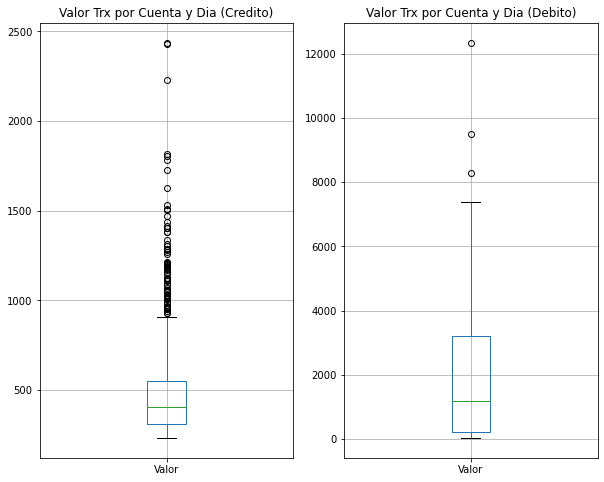

In [16]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
boxplot = base_credito.boxplot(column=['Valor'])
plt.title("Valor Trx por Cuenta y Dia (Credito)")
plt.subplot(1,2,2)
boxplot = base_debito.boxplot(column=['Valor'])
plt.title("Valor Trx por Cuenta y Dia (Debito)")

In [17]:
base_credito['Valor'].describe()

count   1825.000
mean     459.148
std      222.391
min      231.834
25%      309.112
50%      407.368
75%      551.844
max     2436.750
Name: Valor, dtype: float64

In [18]:
base_debito['Valor'].describe()

count   13742.000
mean     1682.193
std      1466.074
min        29.722
25%       232.065
50%      1177.002
75%      3210.006
max     12345.903
Name: Valor, dtype: float64

Para las transacciones de tipo debito el valor minimo es de 29.72, es decir que se realizaron mas de 5 transacciones pero el valor total no es alto, lo anterior nos lleva a tener en cuenta un valor total superior a cierto monto, que para este caso se definira en el cuartil 1, quedando para las transacciones de tipo debito 232.06 y para las transacciones de tipo credito 309.11. 

In [19]:
base_credito=base_credito[base_credito['Valor']>=309.11]
base_debito=base_debito[base_debito['Valor']>=232.06]

In [20]:
print('Cuentas a Revisar por Dia (Credito)')
print('Minimo:',base_credito.groupby('fecha')['account_number'].count().reset_index()['account_number'].min())
print('Media:',round(base_credito.groupby('fecha')['account_number'].count().reset_index()['account_number'].mean(),1))
print('Maximo:',base_credito.groupby('fecha')['account_number'].count().reset_index()['account_number'].max())
print('-----------------------------------')
print('Cuentas a Revisar por Dia (Debito)')
print('Minimo:',base_debito.groupby('fecha')['account_number'].count().reset_index()['account_number'].min())
print('Media:',round(base_debito.groupby('fecha')['account_number'].count().reset_index()['account_number'].mean(),1))
print('Maximo:',base_debito.groupby('fecha')['account_number'].count().reset_index()['account_number'].max())

Cuentas a Revisar por Dia (Credito)
Minimo: 1
Media: 28.1
Maximo: 73
-----------------------------------
Cuentas a Revisar por Dia (Debito)
Minimo: 1
Media: 30.9
Maximo: 175


Con la nueva regla del monto, en promedio se deberian revisar 28 cuentas de transacciones tipo credito y 30 cuentas de transacciones tipo debito, a lo mucho en un dia se revisaria un total de 248 cuentas teniendo los valores maximos en ambos tipos de transacciones.

# Despliegue

Se recomienda realizar la revision de las transacciones todos los dias, teniendo en cuenta las transacciones del dia anterior, de esta manera se es oportuno en las validaciones y el volumen de informacion a manejar no es tan alto.

Por otro lado es necesario que los parametros definidos se ajusten de manera mensual, lo anterior con el fin de garantizar una adecuada gestion de la mala practica transaccional.

Si se maneja el mismo esquema de datos el procedimiento seria el siguiente:

In [21]:
datos_sinteticos=pd.read_parquet('sample_data_0007_part_00.parquet', engine='pyarrow')

datos_sinteticos['transaction_amount'] = datos_sinteticos['transaction_amount'].astype('float64')
datos_sinteticos['fecha'] = pd.to_datetime(datos_sinteticos['transaction_date']).dt.date
datos_sinteticos['fecha'] = pd.to_datetime(datos_sinteticos['fecha'], format='%Y/%m/%d')

In [22]:
# Parametros (la cantidad y valores se deberia ajustar mensualmente)

datos=datos_sinteticos # Se define la base de datos
fecha_analisis="2021-02-09" # Se define la fecha de analisis
cant_deb=5 
cant_cre=39
valor_cre=309.11
valor_deb=232.06

In [23]:
# Codigo para identificar cuales cuentas se deben revisar, al final arroja un resumen

base=datos.groupby(["account_number","transaction_type","fecha"]).agg(
    {'_id':'count','transaction_amount':'sum'}).reset_index()
base = base.rename(columns={'_id':'Cantidad','transaction_amount':'Valor'})
base_credito=base[(base['transaction_type']=='CREDITO') & (base['Cantidad']>=cant_cre) & (base['Valor']>=valor_cre) & (base['fecha']==fecha_analisis)]
base_debito=base[(base['transaction_type']=='DEBITO') & (base['Cantidad']>=cant_deb) & (base['Valor']>=valor_deb) & (base['fecha']==fecha_analisis)]

print("Cuentas para revisar:",len(base_credito['account_number'].unique())+len(base_debito['account_number'].unique()))

print("Cuenta con mayor numero de transacciones Credito (",
      base_credito.sort_values(by=["Cantidad","Valor"],ascending=False).iloc[0,3],
      ") y Valor Total (",
      base_credito.sort_values(by=["Cantidad","Valor"],ascending=False).iloc[0,4],"):",
      base_credito.sort_values(by=["Cantidad","Valor"],ascending=False).iloc[0,0])

print("Cuenta con mayor numero de transacciones Debito (",
      base_debito.sort_values(by=["Cantidad","Valor"],ascending=False).iloc[0,3],
      ") y Valor Total (",
      base_debito.sort_values(by=["Cantidad","Valor"],ascending=False).iloc[0,4],"):",
      base_debito.sort_values(by=["Cantidad","Valor"],ascending=False).iloc[0,0])

base_final=pd.concat([base_credito,base_debito], axis=0)
del base_credito, base_debito, base

Cuentas para revisar: 214
Cuenta con mayor numero de transacciones Credito ( 100 ) y Valor Total ( 2033.00361363 ): 5529a049dc12e545de536321d5d5b6db
Cuenta con mayor numero de transacciones Debito ( 100 ) y Valor Total ( 1283.40783666 ): df88bc1ea83856d0765974f0dbd6cba7


Con el anterior codigo se obtiene la informacion a revisar y es de facil ajuste.